# SBDB Query API

This notebook shows the barebone usage of the [JPL SBDB Query API](https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html) to query "all" the available information for a given object and some explanations. In `ssoloc`, this query can be done by `ssoloc.SBDBQuery` and/or `ssoloc.query.fetch_orb`.

-----

Use the [JPL SBDB Query API](https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html) to 

1. Query "all" the available information


In [1]:
import requests
import pandas as pd
from astropy.time import Time
import numpy as np

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
from matplotlib import pyplot as plt

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})


def print_time(_t0):
    _t = Time.now()
    print(f"Time elapsed: {(_t.jd - _t0.jd)*86400:.2f} sec")
    return _t

In [2]:
#allinfo
r = requests.get("https://ssd-api.jpl.nasa.gov/sbdb_query.api?info=all").json()
# with open("_sbdbq_info.json", "w") as f:
#     f.write(r.text)
cnt = r["info"]["count"]
print("Query time                    :", Time.now().iso)
print("Version information            :", r["signature"])
print(f"Number of available objects now: an={cnt['an']}, cn={cnt['cn']}, au={cnt['au']}, cu={cnt['cu']}")
print("cf. On 2023-12-28              : an=640000, cn=561, au=701042, cu=3349")
print(f"   Changed                     : an={cnt['an']-640000}, cn={cnt['cn']-561}, au={cnt['au']-701042}, cu={cnt['cu']-3349}")
print("                                [a/c = asteroids/comets, n/u = numbered/unnumbered] ")

# print("\nAvailable fields:")
fields_all = []
for k, v in r["info"]["field"].items():
    # print(f"# === {k} ({v['field_label']})")
    for val in v["list"]:
        name = f"\"{val['name']}\""
        unit = val.get("units", None)
        unit = f" [{unit}]" if unit else ""
        # print(f"{name:10s},  #{unit} {val['description']}")
        fields_all.append(val['name'])
print(f"\nTotal: {len(fields_all)} fields (Note: as of 2024-08-02, it's 79)\n")
print("Strangely, compared with https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html, these are missing: ")
print("'kind', 'source', 'soln_date', 'pe_used', 'sb_used', 'S0', 'S0_sigma', 'density', 'pole'")

Query time                    : 2024-08-02 07:49:26.417
Version information            : {'version': '1.0', 'source': 'NASA/JPL SBDB (Small-Body DataBase) Query API'}
Number of available objects now: an=720000, cn=578, au=666302, cu=3380
cf. On 2023-12-28              : an=640000, cn=561, au=701042, cu=3349
   Changed                     : an=80000, cn=17, au=-34740, cu=31
                                [a/c = asteroids/comets, n/u = numbered/unnumbered] 

Total: 79 fields (Note: as of 2024-08-02, it's 79)

Strangely, compared with https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html, these are missing: 
'kind', 'source', 'soln_date', 'pe_used', 'sb_used', 'S0', 'S0_sigma', 'density', 'pole'


In [3]:
fields_all = [
    # === object (Object Fields)
    "spkid"   ,  # object primary SPK-ID
    "full_name",  # object full name/designation
    "kind"    ,  # indicates whether asteroid (a) or comet (c) and whether numbered (n) or unnumbered (u); for example a value of an indicates a numbered asteroid and cu indicates an unnumbered comet
    "pdes"    ,  # object primary designation
    "name"    ,  # object IAU name
    "prefix"  ,  # comet designation prefix
    "neo"     ,  # [Y/N] Near-Earth Object (NEO) flag
    "pha"     ,  # [Y/N] Potentially Hazardous Asteroid (PHA) flag
    "sats"    ,  # Number of known satellites
    # === phys_par (Physical Parameter Fields)
    "H"       ,  # absolute magnitude parameter
    "G"       ,  # magnitude slope parameter (default is 0.15)
    "M1"      ,  # comet total magnitude parameter
    "M2"      ,  # comet nuclear magnitude parameter
    "K1"      ,  # comet total magnitude slope parameter
    "K2"      ,  # comet nuclear magnitude slope parameter
    "PC"      ,  # comet nuclear magnitude law - phase coefficient
    "S0"      ,  # ?? (see comments below)
    "S0_sigma",  # ?? (see comments below)
    "diameter",  # [km] object diameter (from equivalent sphere)
    "extent"  ,  # [km] object bi/tri-axial ellipsoid dimensions
    "albedo"  ,  # geometric albedo
    "rot_per" ,  # [h] rotation period (synodic)
    "pole"    ,  # [deg] spin-pole direction in R.A./Dec.
    "GM"      ,  # [km^3/s^2] standard gravitational parameter: product of the mass (M) and gravitational constant (G)
    "density" ,  # [g/cm^3] bulk density
    "BV"      ,  # color index B-V magnitude difference
    "UB"      ,  # color index U-B magnitude difference
    "IR"      ,  # color index I-R magnitude difference
    "spec_B"  ,  # [SMASSII] spectral taxonomic type
    "spec_T"  ,  # [Tholen] spectral taxonomic type
    "H_sigma" ,  # 1-sigma uncertainty in absolute magnitude H
    # "diameter_sigma",  # [km] 1-sigma uncertainty in object diameter
    # === orbit (Orbit and Model Parameter Fields)
    "orbit_id",  # orbit solution ID
    "epoch"   ,  # [TDB] epoch of osculation in Julian day form
    "epoch_mjd",  # [TDB] epoch of osculation in modified Julian day form
    "epoch_cal",  # [TDB] epoch of osculation in calendar date/time form
    "equinox" ,  # equinox of reference frame
    "e"       ,  # eccentricity
    "a"       ,  # [au] semi-major axis
    "q"       ,  # [au] perihelion distance
    "i"       ,  # [deg] inclination; angle with respect to x-y ecliptic plane
    "om"      ,  # [deg] longitude of the ascending node
    "w"       ,  # [deg] argument of perihelion
    "ma"      ,  # [deg] mean anomaly
    "ad"      ,  # [au] aphelion distance
    "n"       ,  # [deg/d] mean motion
    "tp"      ,  # [TDB] time of perihelion passage
    "tp_cal"  ,  # [TDB] time of perihelion passage
    "per"     ,  # [d] sidereal orbital period
    "per_y"   ,  # [years] sidereal orbital period
    "moid"    ,  # [au] Earth Minimum Orbit Intersection Distance
    "moid_ld" ,  # [LD] Earth Minimum Orbit Intersection Distance
    "moid_jup",  # [au] Jupiter Minimum Orbit Intersection Distance
    "t_jup"   ,  # Jupiter Tisserand Invariant
    "sigma_e" ,  # eccentricity (1-sigma uncertainty)
    "sigma_a" ,  # [au] semi-major axis (1-sigma uncertainty)
    "sigma_q" ,  # [au] perihelion distance (1-sigma uncertainty)
    "sigma_i" ,  # [deg] inclination (1-sigma uncertainty)
    "sigma_om",  # [deg] long. of the asc. node (1-sigma uncertainty)
    "sigma_w" ,  # [deg] argument of perihelion (1-sigma uncertainty)
    "sigma_ma",  # [deg] mean anomaly (1-sigma uncertainty)
    "sigma_ad",  # [au] aphelion distance (1-sigma uncertainty)
    "sigma_n" ,  # [deg/d] mean motion (1-sigma uncertainty)
    "sigma_tp",  # [d] time of peri. passage (1-sigma uncertainty)
    "sigma_per",  # [d] sidereal orbital period (1-sigma uncertainty)
    "class"   ,  # orbit classification
    "source"  ,  # code indicating the source of the orbit: ORB=”JPL orbit file”, MPC:mpn=”MPC numbered asteroid orbit file”, MPC:mpu=”MPC unnumbered asteroid orbit file”, MPC:mp1=”MPC single opposition short-arc orbit file”
    "soln_date",  # date/time of orbit determination (YYYY-MM-DD hh:mm:ss, Pacific Local)
    "producer",  # name of person (or institution) who computed the orbit
    "data_arc",  # [d] number of days spanned by the data-arc
    "first_obs",  # [UT] date of first observation used in the orbit fit
    "last_obs",  # [UT] date of last observation used in the orbit fit
    "n_obs_used",  # number of observations (all types) used in fit
    "n_del_obs_used",  # number of delay-radar observations used in fit
    "n_dop_obs_used",  # number of Doppler-radar observations used in fit
    "pe_used" ,  # JPL internal ID of the planetary ephemeris used in the OD
    "sb_used" ,  # JPL internal ID of the small-body ephemeris used in the OD
    "condition_code",  # orbit condition code (MPC 'U' parameter)
    "rms"     ,  # [arcsec] normalized RMS of orbit fit
    "two_body",  # [T/F] 2-body dynamics used flag
    "A1"      ,  # non-grav. radial parameter
    "A1_sigma",  # non-grav. radial parameter (1-sigma uncertainty)
    "A2"      ,  # non-grav. transverse parameter
    "A2_sigma",  # non-grav. transverse parameter (1-sigma uncertainty)
    "A3"      ,  # non-grav. normal parameter
    "A3_sigma",  # non-grav. normal parameter (1-sigma uncertainty)
    "DT"      ,  # [d] non-grav. peri.-maximum offset
    "DT_sigma",  # [d] non-grav. peri.-maximum offset (1-sigma uncertainty)
]
fields_aonly = ["H", "G", "pha", "BV", "UB", "IR", "spec_B", "spec_T", "H_sigma"]
fields_conly = ["prefix", "M1", "M2", "K1", "K2", "PC"]
fields_ignore = [
    "S0", "S0_sigma", "diameter", "extent", "pole", "GM", "density",
    "BV", "UB", "IR", "equinox", "epoch_mjd", "epoch_cal", "n", "sigma_n",
    "tp_cal", "moid_ld", "producer",
]

Among them, these can be ignored (as of 2024-Aug):
* `equinox`: All are "J2000". Check the link below to see any entry with equinox != "J2000".
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,equinox&full-prec=1&sb-cdata={%22OR%22:[%22equinox|NE|J2000%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,equinox&full-prec=1&sb-cdata={%22OR%22:[%22equinox|NE|J2000%22]})
* `S0[_sigma]`: Only 1P has non-null values (S0=575.773139, S0_sigma=27.25). 
  * Even more strangely, when `S0_sigma` is in the `"fields"`, a format error is raised after long time of querying (omg). I will ignore these..
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,S0,S0_sigma&full-prec=1&sb-cdata={%22OR%22:[%22S0|DF%22,%22S0_sigma|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,pole,S0,S0_sigma&full-prec=1&sb-cdata={%22OR%22:[%22S0|DF%22,%22S0_sigma|DF%22]})
* `pole`, `GM`, `density`: Only 13, 16, 18 objects, respectively, have them. 
  * `pole` are given pole in a non-unified format. 
  * I guess one should use other research articles (or DAMIT) for these quantities and ignore JPL/SBDB values.
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,pole&sb-cdata={%22OR%22:[%22pole|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,pole&sb-cdata={%22OR%22:[%22pole|DF%22]})
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,GM&full-prec=1&sb-cdata={%22OR%22:[%22GM|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,GM&full-prec=1&sb-cdata={%22OR%22:[%22GM|DF%22]})
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,density&full-prec=1&sb-cdata={%22OR%22:[%22density|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,density&full-prec=1&sb-cdata={%22OR%22:[%22density|DF%22]})
  
* `epoch_mjd`: Unnecessary (use `epoch`)
* `BV`, `UB`, `IR`: Not really necessary...?
  * Only 1021 objects have at least one of these (only Bennu has IR).
    * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,UB,BV,IR&full-prec=1&sb-cdata={%22OR%22:[%22UB|DF%22,%22BV|DF%22,%22IR|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,UB,BV,IR&full-prec=1&sb-cdata={%22OR%22:[%22UB|DF%22,%22BV|DF%22,%22IR|DF%22]})
  * Only 73 objects have at least one of these **without** a known spectral type
    * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,UB,BV,IR,spec_B,spec_T&full-prec=1&sb-cdata={%22AND%22:[{%22AND%22:[%22spec_B|ND%22,%22spec_T|ND%22]},{%22OR%22:[%22UB|DF%22,%22BV|DF%22,%22IR|DF%22]}]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,UB,BV,IR,spec_B,spec_T&full-prec=1&sb-cdata={%22AND%22:[{%22AND%22:[%22spec_B|ND%22,%22spec_T|ND%22]},{%22OR%22:[%22UB|DF%22,%22BV|DF%22,%22IR|DF%22]}]})
  * For reference, 2174 objects have at least one known spectral type
    * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,spec_B,spec_T&full-prec=1&sb-cdata={%22OR%22:[%22spec_B|DF%22,%22spec_T|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,spec_B,spec_T&full-prec=1&sb-cdata={%22OR%22:[%22spec_B|DF%22,%22spec_T|DF%22]})
  * However, one should use the most recently updated, separate catalog (e.g., SMASS) for better accuracy (...?)
* `producer`, `pe_used`, `sb_used`, `orbit_id`: Unnecessary?


Following are unnecessary:
* `epoch_cal`: use `epoch`
* `tp_cal`: use `tp`
* `[sigma_]a/n/ad/n/per`: SPICE uses these q,e,i,om,w,ma,tp,epoch. a=q/(1-e), ad=q*(1+e)/(1-e), etc.
* `per_y`: use `q` and `e`, or even `per/365.25`
* `moid_ld`: use `moid`

Note:
* At the moment(2024-07-27), prefix is only C/P/D/A. There are only 18 A-prefixed objects (used to be 20 in 2024 Mar), which are all accessible with `sb-kind` of `"a"`.
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,prefix,condition_code&full-prec=1&sb-cdata={%22AND%22:[%22prefix|DF%22,%22prefix|RE|[^CPD]%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,prefix,condition_code&full-prec=1&sb-cdata={%22AND%22:[%22prefix|DF%22,%22prefix|RE|[^CPD]%22]})
* At the moment, there are 670 objects (364 asteroids (41 with `condition_code != 0`), 306 comets) with tabulated non-gravitational parameter(s) 
  * [https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,A1,A2,A3,DT&full-prec=1&sb-cdata={%22OR%22:[%22A1|DF%22,%22A2|DF%22,%22A3|DF%22,%22DT|DF%22]}](https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=spkid,full_name,A1,A2,A3,DT&full-prec=1&sb-cdata={%22OR%22:[%22A1|DF%22,%22A2|DF%22,%22A3|DF%22,%22DT|DF%22]})

## Important Note
You can use something like this to maintain the list up-to-date:
```python
DATE = "2024-08-01"
# Testing for newly updated objects:
# 1. Asteroids
_fields = [_f for _f in fields_all if _f not in fields_conly+fields_ignore]
_constraint = {"sb-kind": "a", "sb-cdata": f'{"OR":["soln_date|GT|{DATE}"]}'}
r = requests.get(
    "https://ssd-api.jpl.nasa.gov/sbdb_query.api?",
    params={"fields": ",".join(_fields), "full-prec": 1} | _constraint
).json()

# 2. Comets
_fields = [_f for _f in fields_all if _f not in fields_aonly+fields_ignore]
_constraint = {"sb-kind": "a", "sb-cdata": f'{"OR":["soln_date|GT|{DATE}"]}'}
r = requests.get(
    "https://ssd-api.jpl.nasa.gov/sbdb_query.api?",
    params={"fields": ",".join(_fields), "full-prec": 1} | _constraint
).json()

```

One remaining question: About half of asteroids are "unnumbered". A simple approach is to ignore any unnumbered asteroids and consider those with permanent designation numbers (so that we don't have to worry about an object disappearing in the future).

## Query SBDB

Below, we will query all important columns of all SBDB objects.

It takes ~ 10s for comets (total ~4000 entries), and ~10min for asteroids (total ~ 1.3M entries)

In [4]:
date = Time.now().iso[:10]
# for ac in ["cp", "cc", "a1", "a0"]:
for ac in ["c", "a"]:
    print(f"Getting {ac}...")
    _t1 = Time.now()
    if ac == "a":
        _fields = [_f for _f in fields_all if _f not in fields_conly + fields_ignore]
        _constraint = {"sb-kind": "a"}
    elif ac == "c":
        _fields = [_f for _f in fields_all if _f not in fields_aonly + fields_ignore]
        _constraint = {"sb-kind": "c"}
    # if ac == "a0":
    #     _fields = [_f for _f in fields_all if _f not in ["prefix", "M1", "M2", "K1", "K2", "PC"]]
    #     _constraint = {"sb-kind": "a", "sb-cdata": '{"AND":["condition_code|EQ|0"]}'}
    # elif ac == "a1":
    #     _fields = [_f for _f in fields_all if _f not in ["prefix", "M1", "M2", "K1", "K2", "PC"]]
    #     _constraint = {"sb-kind": "a", "sb-cdata": '{"AND":["condition_code|NE|0"]}'}
    # elif ac == "cc":
    #     _fields = [_f for _f in fields_all if _f not in ["H", "G", "pha", "BV", "UB", "IR", "spec_B", "spec_T", "H_sigma"]]
    #     _constraint = {"sb-kind": "c", "sb-cdata": '{"AND":["prefix|EQ|C"]}'}
    # elif ac == "cp":
    #     _fields = [_f for _f in fields_all if _f not in ["H", "G", "pha", "BV", "UB", "IR", "spec_B", "spec_T", "H_sigma"]]
    #     _constraint = {"sb-kind": "c", "sb-cdata": '{"AND":["prefix|EQ|P"]}'}

    r = requests.get(
        "https://ssd-api.jpl.nasa.gov/sbdb_query.api?",
        params={"fields": ",".join(_fields), "full-prec": 1} | _constraint
    ).json()
    _t2 = print_time(_t1)
    pd.DataFrame(r["data"], columns=_fields).to_parquet(
        f"sbdb_{ac}_{date}.parq", index=False
    )
    _t3 = print_time(_t2)

Getting c...
Time elapsed: 2.57 sec
Time elapsed: 0.06 sec
Getting a...
Time elapsed: 887.65 sec
Time elapsed: 13.06 sec


In [5]:
dfa = pd.read_parquet(f"sbdb_a_{date}.parq")
dfc = pd.read_parquet(f"sbdb_c_{date}.parq")

## A Test Plot
Condition code (aka IAU U-parameter; [wikipedia](https://en.wikipedia.org/wiki/Uncertainty_parameter)) is defined as the error-bar of longitude (ignoring latitude) after 10 years.

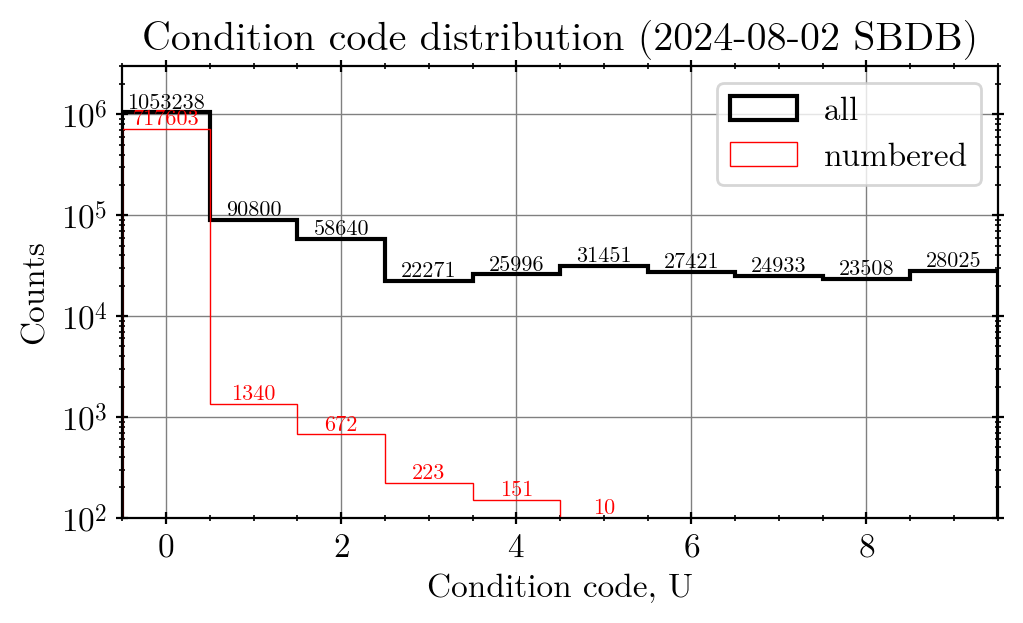

In [6]:
dfa_an = dfa.loc[dfa["kind"]=="an"].copy()
dfa_no_def = dfa.loc[dfa["condition_code"].isin(list("0123456789"))].copy()["condition_code"]
uvals = dfa_no_def.astype(float)
uvals_an = dfa_an["condition_code"].astype(float)

fig, axs = plt.subplots(1, 1, figsize=(5, 3), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

axs.hist(uvals, bins=np.arange(-0.5, 10.5, 1), histtype="step", lw=1.5, color="k", label="all")
axs.hist(uvals_an, bins=np.arange(-0.5, 10.5, 1), histtype="step", lw=0.5, color="r", label="numbered")
for i, v in uvals.value_counts().sort_index().items():
    axs.text(i, v, f"{v}", ha="center", va="bottom", fontsize=8)
for i, v in uvals_an.value_counts().sort_index().items():
    axs.text(i, max(v, 100), f"{v}", ha="center", va="bottom", color="r", fontsize=8)
axs.set(
    xlim=(-0.5, 9.5), ylim=(1.e+2, 3.e+6),
    yscale="log",
    xlabel="Condition code, U", ylabel="Counts", title=f"Condition code distribution ({date} SBDB)"
)
axs.legend()
plt.show();
